In [1]:
import matplotlib.pyplot as plt
import nir
import numpy as np

import sys
sys.path.append("/Users/steve/Code/NIR/paper")

from nir_to_lava import ImportConfig, LavaLibrary, import_from_nir

Setup:

In [2]:
def load_data():
    isis = [
        6, 15, 4, 3, 0, 2, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 
        0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 14
    ]
    d1 = list(np.concatenate([isi*[0]+[1] for isi in isis]))[:100]
    d = np.array([[e] + 9*[0] for e in d1]).reshape(1, -1)
    return d

config = ImportConfig(
    # dt=1e-4, fixed_pt=True, on_chip=False, library_preference=LavaLibrary.Lava
    dt=1e-4, fixed_pt=False, on_chip=False, library_preference=LavaLibrary.Lava
)

Lava imports:

In [3]:
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg, Loihi2HwCfg
from lava.proc.io.source import RingBuffer

if config.on_chip:
    from lava.proc.io.sink import RingBuffer as Sink
    from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter
    from lava.utils.loihi2_state_probes import StateProbe

Load data and convert NIR graph to Lava:

In [4]:
d = load_data()
ng = nir.read("lif_norse.nir")
lava_nodes, start_nodes, end_nodes = import_from_nir(ng, config)

Configure input and output to the Lava network:

In [5]:
ring_buffer = RingBuffer(data=d)
lif = lava_nodes['1'][1]
dense = lava_nodes['0']

if config.on_chip:
    sink = Sink(shape=(1,), buffer=d.shape[1])
    py2nx = PyToNxAdapter(shape=(1,))
    nx2py = NxToPyAdapter(shape=(1,))

    ring_buffer.s_out.connect(py2nx.inp)
    py2nx.out.connect(dense.s_in)
    dense.a_out.connect(lif.a_in)
    lif.s_out.connect(nx2py.inp)
    nx2py.out.connect(sink.a_in)
else:
    ring_buffer.s_out.connect(lava_nodes['0'].s_in)

Configure probes to record spikes and voltages from the Lava network:

In [6]:
n_steps = 1000

if config.on_chip:
    probe_v = StateProbe(lif.v)
    probe_u = StateProbe(lif.u)
    callbacks = [probe_v, probe_u]
    run_cfg = Loihi2HwCfg(callback_fxs=callbacks)
else:
    mon_volt = Monitor()
    mon_curr = Monitor()
    mon_spk = Monitor()
    mon_inp = Monitor()
    mon_volt.probe(lif.v, n_steps)
    mon_curr.probe(lif.u, n_steps)
    mon_spk.probe(lif.s_out, n_steps)
    mon_inp.probe(ring_buffer.s_out, n_steps)
    tag = "fixed_pt" if config.fixed_pt else "floating_pt"
    run_cfg = Loihi2SimCfg(select_tag=tag)

print('start running')
lif.run(condition=RunSteps(num_steps=n_steps), run_cfg=run_cfg)
if config.on_chip:
    sink_data = sink.data.get()
    lif.stop()
print('getting data')

start running
getting data


Plot the results:

spikes: (1000,), voltage: (1000,)


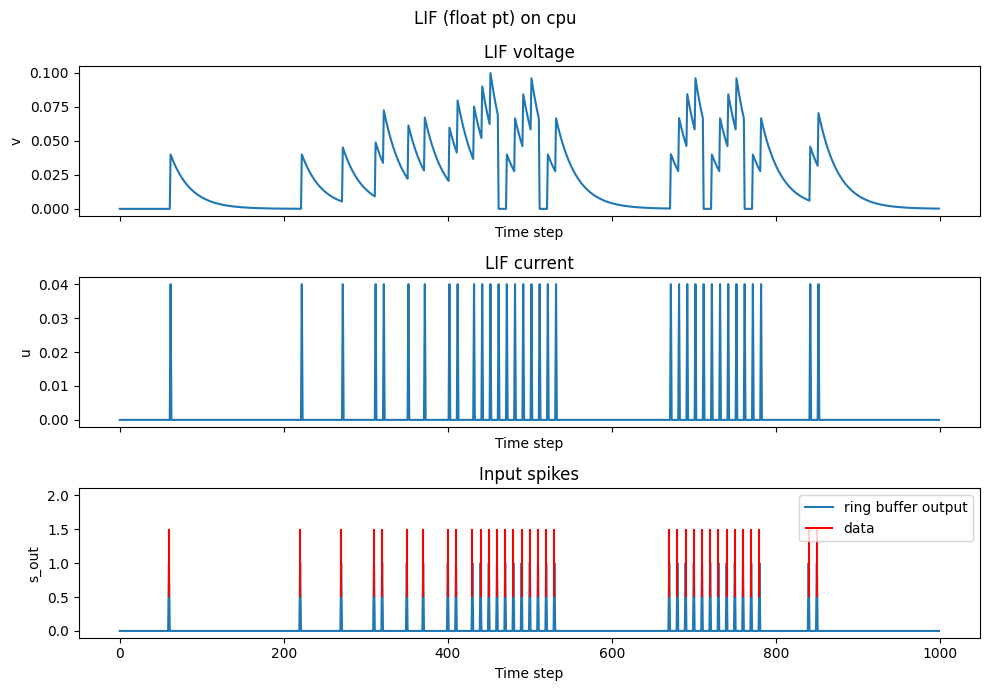

In [9]:
inp_spikes = d.reshape(-1)

if config.on_chip:
    spikes = sink_data.reshape(-1)
    voltage = probe_v.time_series.reshape(-1)
    print(f'spikes: {spikes.shape}, voltage: {voltage.shape}')
else:
    spikes = mon_spk.get_data()['lif']['s_out'].reshape(-1)
    voltage = mon_volt.get_data()['lif']['v'].reshape(-1)
    print(f'spikes: {spikes.shape}, voltage: {voltage.shape}')

sfx = 'fixed' if config.fixed_pt else 'float'
device = 'loihi' if config.on_chip else 'cpu'
with open(f'lif_lava_{device}_{sfx}.csv', 'w') as fw:
    for idx in range(inp_spikes.shape[0]):
        fw.write(f'{inp_spikes[idx]},{voltage[idx]},{spikes[idx]}\n')

fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
fig.suptitle(f'LIF ({sfx} pt) on {device}')
# fig.suptitle(f'LIF ({sfx} pt) on {device} with du={du}, dv={dv}, vth={vthr}')
mon_volt.plot(axs[0], lif.v)
mon_curr.plot(axs[1], lif.u)
mon_inp.plot(axs[2], ring_buffer.s_out, label='ring buffer output')
axs[2].eventplot(np.argwhere(d.reshape(-1) > 0).reshape(-1), color='r', label='data')
axs[2].legend()
# axs[2].set_xticks(np.arange(0, n_steps, 1), minor=True)
axs[0].set_title('LIF voltage')
axs[1].set_title('LIF current')
axs[2].set_title('Input spikes')
plt.tight_layout()
plt.savefig(f'lif_lava_{device}_{sfx}.png')
plt.show()